In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import pandas as pd

In [5]:
# Ellipses
# All files needed
from scipy.stats import gaussian_kde
from matplotlib.patches import Ellipse
from scipy.stats import chi2

In [8]:
import sys
sys.path.append('/Users/jackcarter/Documents/Initial_Thorium/')
# Need to apply path to get to this code package. 
from Initial_Thorium_Codes import Hellstrom_Age_Correction

In [9]:
# Simple sample generator for getting reasonably spaced 
# initial thoirum corrections
def Get_inT_Samples(): 
    minimum = 1e-5
    maximum = 300
    U = np.random.rand()
    inT_sample = minimum *(maximum/minimum)**U
    return inT_sample

In [10]:
# Import Cheng Data 
df = pd.read_excel('/Users/jackcarter/Documents/IBIS/Cheng_2018_MSD_data_clean_up.xlsx')

In [12]:
df_rows = df.iloc[9:19]

In [119]:
df_rows.to_excel('Cheng_2018_MSD_subset.xlsx')

In [13]:
# Assuming df_rows is defined, and it's your DataFrame sliced for each row operation
# Setup zeros arrays for storage
ages = np.zeros((df_rows.shape[0], 10000))
initial_thoriums = np.zeros((df_rows.shape[0], 10000))

for j in range(df_rows.shape[0]):
    for i in range(10000):
        # Sample initial thorium levels
        ini_thor = Get_inT_Samples()
        
        # Perform age correction using sampled initial thorium levels
        inst = Hellstrom_Age_Correction.Age_Hellstrom(df_rows[j:j+1], r02_initial=ini_thor)
        age_ini_thor = inst.Monte_Carlo_Sampler()

        # Store each sample in the respective arrays
        initial_thoriums[j, i] = ini_thor
        ages[j, i] = age_ini_thor

In [17]:
labels = []
for j in range(df_rows.shape[0]): 
    labels.append(df_rows[j:j+1]['Sample'].values.item())

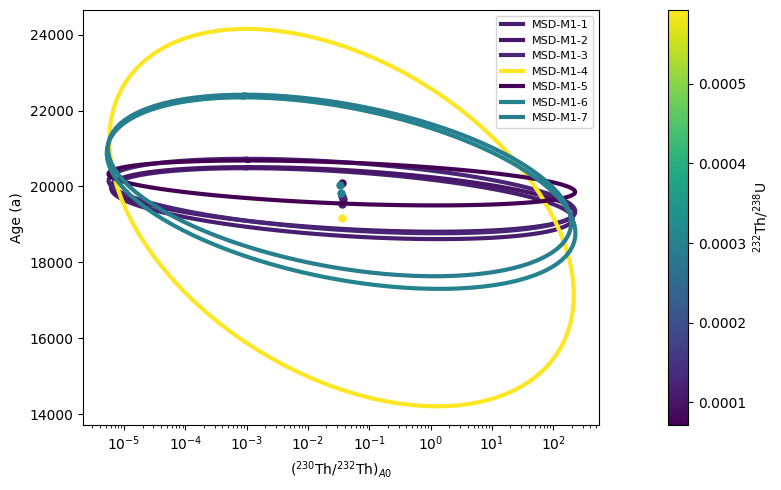

In [20]:
# Packages needed for the ellipses plot
import matplotlib.colors as mcolors
import matplotlib.cm as cm


th232_values = df_rows['Th_232_r'].values
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=th232_values.min(), vmax=th232_values.max())

# Get Ellipses in log space
ellipse_log_coords = []
ellipse_age_coords = []
center_log = []
colors_used = []
for i in range(initial_thoriums.shape[0] - 3):
    color = cmap(norm(th232_values[i]))
    colors_used.append(color)
    
    init_clipped = np.clip(initial_thoriums[i, :], 1e-15, np.log(300))
    init_log = np.log(init_clipped)
    mean_log = np.mean(init_log)
    mean_age = np.mean(ages[i, :])
    covar = np.cov(init_log, ages[i, :])
    
    # Ellipses parameters
    vals, vecs = np.linalg.eigh(covar)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.arctan2(vecs[1, 0], vecs[0, 0])
    a = 2 * np.sqrt(vals[0])
    b = 2 * np.sqrt(vals[1])
    
    t = np.linspace(0, 2*np.pi, 100)
    ellipse_log_x = mean_log + a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta)
    ellipse_y = mean_age + a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta)
    
    ellipse_log_coords.append(ellipse_log_x)
    ellipse_age_coords.append(ellipse_y)
    center_log.append((mean_log, mean_age))

# Now, let's create a plot with the x-axis in the original (linear) space.
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(ellipse_log_coords)):
    # Convert the ellipse x-coordinates from log-space back to linear:
    ellipse_linear_x = np.exp(ellipse_log_coords[i])
    ax.plot(ellipse_linear_x, ellipse_age_coords[i], color=colors_used[i], lw=3, label=labels[i])
    
    # Also plot the center (transformed back to linear):
    center_lin = np.exp(center_log[i][0])
    ax.plot(center_lin, center_log[i][1], marker='o', color=colors_used[i], markersize=5)

ax.set_xlabel("($^{230}$Th/$^{232}$Th)$_{A0}$")
ax.set_ylabel("Age (a)")
ax.set_xscale('log')


# Optionally add a colorbar based on Th_232_r
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label("$^{232}$Th/$^{238}$U")

ax.legend(fontsize=8)
plt.tight_layout()
